<a href="https://colab.research.google.com/github/toussyn/delivery_app_causal_inference/blob/oju/notebooks/causal_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Causal Inference

In [57]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [58]:
pip install causalnex==0.11.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [59]:
!apt install libgraphviz-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgraphviz-dev is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.


In [60]:
!pip install pygraphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import necessary libraries

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from causalnex.structure import StructureModel
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
from sklearn.preprocessing import LabelEncoder
from causalnex.structure.notears import from_pandas
import networkx as nx
from causalnex.network import BayesianNetwork
from causalnex.discretiser import Discretiser
from sklearn.model_selection import train_test_split
from causalnex.evaluation import classification_report
from causalnex.evaluation import roc_auc
from causalnex.inference import InferenceEngine
import graphviz

In [79]:
df = pd.read_csv('My Drive/10X/Gokada/clean_df.csv')
df.head()

Dropping unnecessary columns 

In [71]:
df.drop(['Unnamed: 0', 'Trip Start Time', 'day_of_week', 'order_id', 'driver_id', 'day_of_week_num', 'day_of_month'], axis=1, inplace=True)
df.head()

,driver_action,Duration_Minutes,trip_distance,Speed_kmh,driver_distance,hour,is_weekend
0,1,3.616667,20.984319,348.126952,8.112927,9,0
1,0,0.000000,0.000000,0.000000,8.112927,9,0
2,0,0.000000,0.000000,0.000000,8.112927,9,0
3,0,0.000000,0.000000,0.000000,8.112927,9,0
4,0,0.000000,0.000000,0.000000,8.112927,9,0


## Structure Learning
We can use CausalNex to learn the structure model from data. The structure learning algorithm we are going to use here is the NOTEARS algorithm.

When learning structure, we can use the entire dataset. Since structure should be considered as a joint effort between machine learning and domain experts, it is not always necessary to use a train / test split.

But before we begin, we have to pre-process the data so that the NOTEARS algorithm can be used.

### Preparing the Data for Structure Learning
Upon inspection of the data, we can see that all features consist of numeric columns. This is good, since this is what the NOTEARS expects.

In [72]:
struct_df = df.copy()
struct_df.dtypes

driver_action         int64
Duration_Minutes    float64
trip_distance       float64
Speed_kmh           float64
driver_distance     float64
hour                  int64
is_weekend            int64
dtype: object

That means we can apply the NOTEARS algorithm to learn the structure.

In [73]:
sm = from_pandas(struct_df)

and visualise the learned StructureModel using the plot function.

/usr/local/lib/python3.7/dist-packages/pygraphviz/agraph.py:1390: RuntimeWarning: Warning: node 'driver_action', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


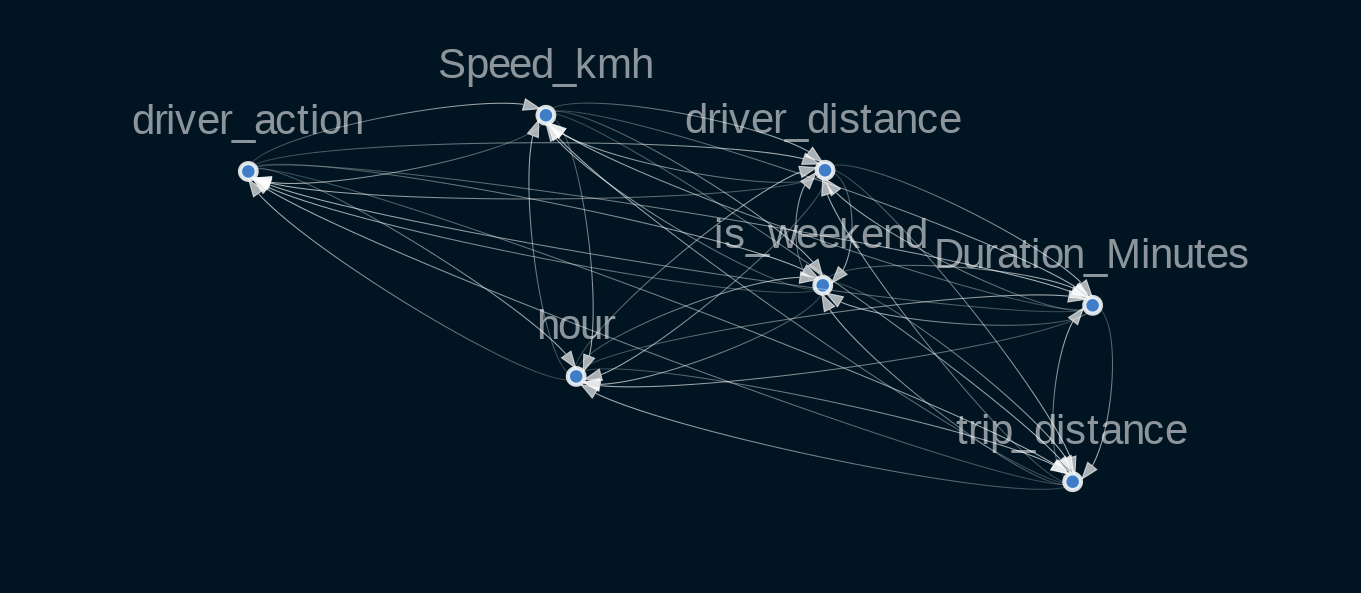

In [74]:
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
    prog='fdp',
)
Image(viz.draw(format='png'))

The reason why we have a fully connected graph here is we haven’t applied thresholding to the weaker edges. 

/usr/local/lib/python3.7/dist-packages/pygraphviz/agraph.py:1390: RuntimeWarning: Warning: node 'driver_action', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


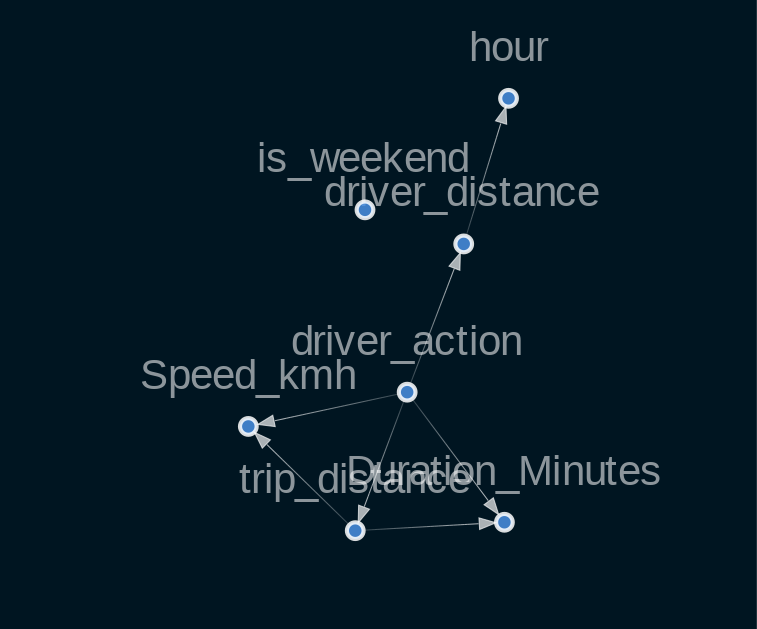

In [85]:
sm.remove_edges_below_threshold(0.8)
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

Correct erroneous relationships

In [86]:
# Modifying the edges
sm.remove_edge("driver_distance", "is_weekend")
sm.remove_edge("driver_action", "trip_distance")
sm.remove_edge("driver_action", "Duration_Minutes")

We can now visualise our updated structure to confirm it looks reasonable.

/usr/local/lib/python3.7/dist-packages/pygraphviz/agraph.py:1390: RuntimeWarning: Warning: node 'driver_action', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/pygraphviz/agraph.py:1390: RuntimeWarning: Warning: node 'driver_action', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


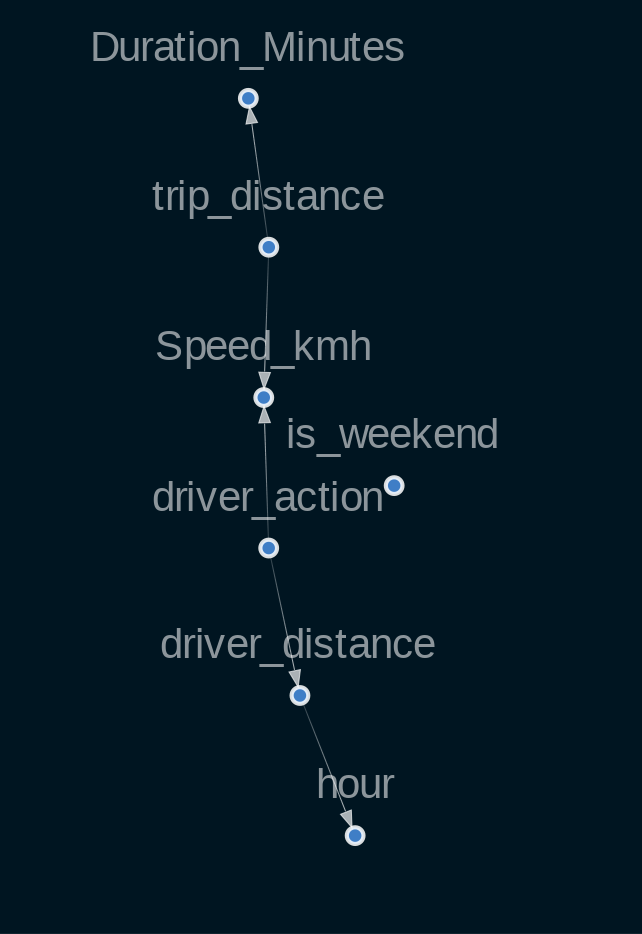

In [87]:
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

/usr/local/lib/python3.7/dist-packages/pygraphviz/agraph.py:1390: RuntimeWarning: Warning: node 'driver_action', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/pygraphviz/agraph.py:1390: RuntimeWarning: Warning: node 'driver_action', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


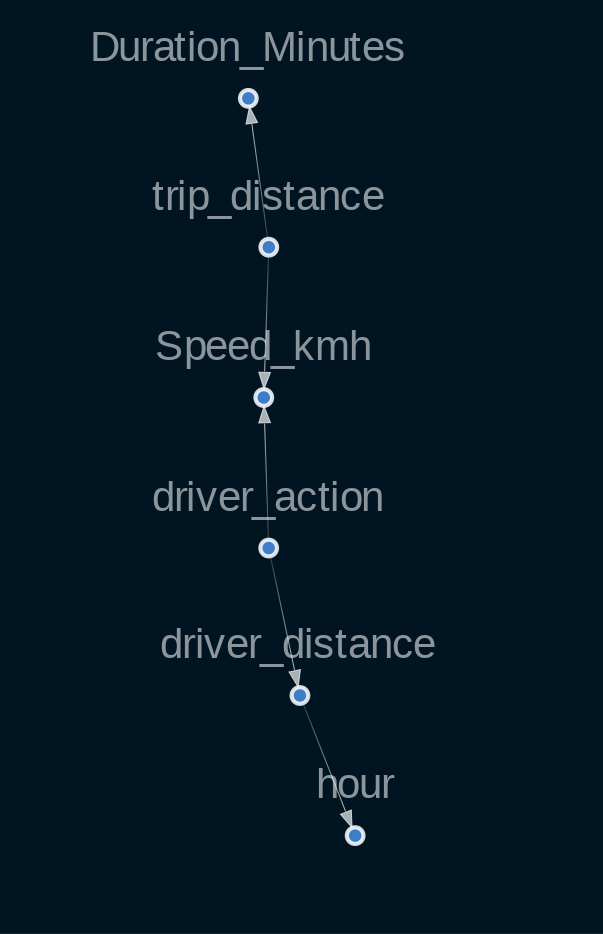

In [88]:
sm = sm.get_largest_subgraph()
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

In [89]:
nx.drawing.nx_pydot.write_dot(sm, 'My Drive/10X/Gokada/gkgraph.dot')

## Fitting the Conditional Distribution of the Bayesian Network
Instantiating a BayesianNetwork.

In [90]:
bn = BayesianNetwork(sm)

/usr/local/lib/python3.7/dist-packages/pgmpy/models/BayesianModel.py:10: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  FutureWarning,


We are now ready to move on to learning the conditional probability distribution of different features in the BayesianNetwork.

### Cardinality of Categorical Features


In [78]:
discretised_data = df.copy()
discretised_data['is_weekend'] = discretised_data['is_weekend'].apply(lambda x: 'weekday' if x == 0 else "weekend")
discretised_data['driver_action'] = discretised_data['driver_action'].apply(lambda x: 'rejected' if x == 0 else "accepted")
discretised_data.head()

,driver_action,Duration_Minutes,trip_distance,Speed_kmh,driver_distance,hour,is_weekend
0,accepted,3.616667,20.984319,348.126952,8.112927,9,weekday
1,rejected,0.000000,0.000000,0.000000,8.112927,9,weekday
2,rejected,0.000000,0.000000,0.000000,8.112927,9,weekday
3,rejected,0.000000,0.000000,0.000000,8.112927,9,weekday
4,rejected,0.000000,0.000000,0.000000,8.112927,9,weekday


### Discretising Numeric Features


In [95]:
discretised_data["driver_distance"] = Discretiser(method="fixed",
        numeric_split_points=[1,5]).transform(discretised_data["driver_distance"].values)
discretised_data["driver_distance"].value_counts()

1    1555718
Name: driver_distance, dtype: int64